## 1. Importing libraries and loading the dataset

In [1]:
# numeric operations library (commonly used for arrays, stats, etc.)
import numpy as np

# data manipulation library
import pandas as pd
# filesystem utilities for listing and joining file paths
import os

# list files in the data directory
data = os.listdir("/Users/chinmaybhosale/code/my-projects/Marketing-funnel-conversion-analysis/data")
# use the filenames as-is (can filter or sort here if needed)
files = [file for file in data]

# read all CSV files in the data directory and concatenate them into one DataFrame
df = pd.concat((pd.read_csv(os.path.join('data', file)) for file in files), ignore_index=True)

# display the first few rows to confirm successful load
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


## 2. Data cleaning and preparation

In [2]:
# Drop any rows with missing values to avoid errors in downstream aggregations
df = df.dropna()

# Convert the event_time column to datetime so we can perform time-based operations and sorting
df["event_time"] = pd.to_datetime(df["event_time"])
# (this will infer/attach timezone if present in the timestamp strings)

# Filter to keep only funnel-relevant event types so subsequent analyses focus on view → cart → purchase
df = df[df["event_type"].isin(["view", "cart", "purchase"])]

# After these steps, `df` is cleaned and ready for funnel calculations, segmentation, and time-to-conversion analysis

## 3. Funnel stages


 | Funnel Stage | Event Type |
 | ------------ | ---------- |
 | Visit        | view       |
 | Add to Cart  | cart       |
 | Purchase     | purchase   |


In [3]:
# Defining funnel stages for a meaningful conversion rates
funnel = df.groupby("event_type")["user_id"].nunique().reset_index()
funnel

,event_type,user_id
0,cart,20498
1,purchase,8461
2,view,61624


## 4. Conversion rate calculation

In [4]:
# visit_users, cart_users, purchase_users: unique user counts per funnel stage
visit_users = funnel[funnel["event_type"]=="view"]["user_id"].values[0]
cart_users = funnel[funnel["event_type"]=="cart"]["user_id"].values[0]
purchase_users = funnel[funnel["event_type"]=="purchase"]["user_id"].values[0]

# cart_conversion: fraction of viewers who added to cart (cart_users / visit_users)
cart_conversion = cart_users / visit_users

# purchase_conversion: fraction of cart users who completed purchase (purchase_users / cart_users)
purchase_conversion = purchase_users / cart_users

# overall_conversion: fraction of viewers who completed purchase (purchase_users / visit_users)
overall_conversion = purchase_users / visit_users

## 5. Funnel drop-off analysis

In [5]:
# Compute drop-off rates as 1 - conversion_rate for each funnel step

# dropoff_view_to_cart: fraction of viewers who did NOT add to cart
dropoff_view_to_cart = 1 - cart_conversion

# dropoff_cart_to_purchase: fraction of cart users who did NOT complete purchase
dropoff_cart_to_purchase = 1 - purchase_conversion

# Print the numeric drop-off fractions to the notebook output for quick inspection
print(f"Drop-offs after view and adding to cart: {round(dropoff_view_to_cart * 100, 2)}%")
print(f"Drop-offs after adding to cart and checkout: {round(dropoff_cart_to_purchase * 100, 2)}%")

Drop-offs after view and adding to cart: 66.74%
Drop-offs after adding to cart and checkout: 58.72%


#### High View → Cart drop-off → product page problem
#### High Cart → Purchase drop-off → checkout or pricing problem

## 6. Funnel segmentation

### A. Product category funnel

In [6]:
df.groupby(['category_code', 'event_type'])['user_id'].nunique()

category_code                           event_type
accessories.bag                         cart            106
                                        purchase         32
                                        view           2304
accessories.cosmetic_bag                cart            136
                                        purchase         39
                                        view            699
apparel.glove                           cart           5881
                                        purchase       2701
                                        view           7378
appliances.environment.air_conditioner  cart             97
                                        purchase         29
                                        view            289
appliances.environment.vacuum           cart           7958
                                        purchase       2825
                                        view          32321
appliances.personal.hair_cutter         cart     

### B. Price band analysis

In [7]:
df["price_band"] = pd.cut(df["price"], bins=[0,50,100,200,500,1000])

### High price items drops at cart stage
### Low price items convert faster

## 7. Time-to-conversion analysis

In [8]:
# purchase_times holds only rows where event_type == "purchase"
purchase_times = df[df["event_type"]=="purchase"]

print(f"Number of pruchases: {purchase_times.shape[0]}")

# Use purchase_times for downstream analyses: revenue, purchase funnel timestamps,
# time-to-conversion, session-level aggregation, or plotting purchase volume over time
# e.g., group by event_time.dt.date to get daily purchase counts or sum(price) for daily revenue

Number of pruchases: 13847


## 8. Visualization

### Funnel chart (users per stage)

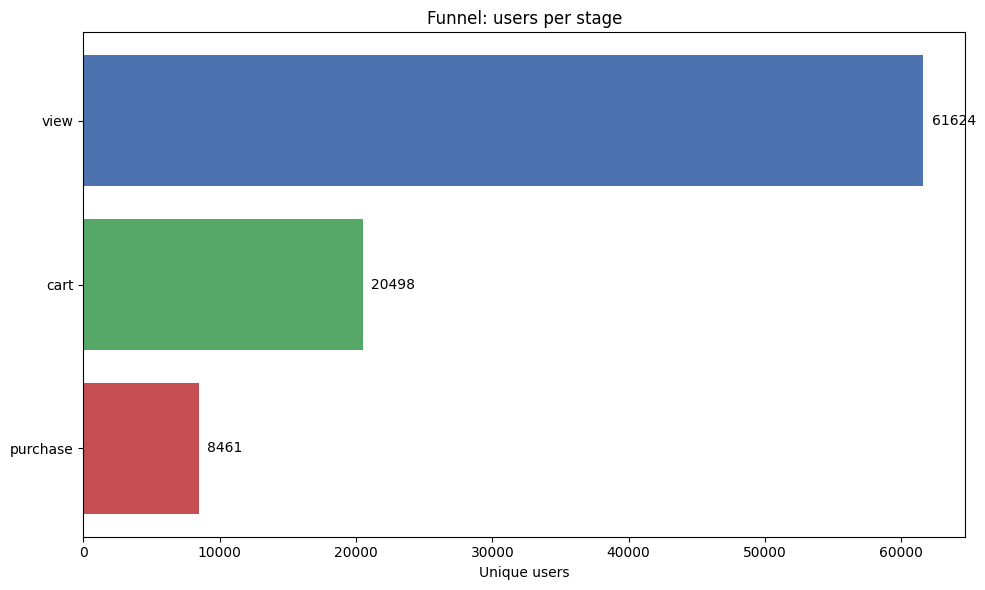

In [9]:
# Create a horizontal bar chart showing unique users at each funnel stage.
import matplotlib.pyplot as plt

# 'stages' defines the desired order; 'counts' is derived from the funnel DataFrame.
stages = ['view', 'cart', 'purchase']
counts = funnel.set_index('event_type')['user_id'].reindex(stages).fillna(0).astype(int)

# Configure figure size and colors, draw bars, and annotate each bar with its numeric value.
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(stages, counts, color=['#4c72b0', '#55a868', '#c44e52'])
for i, (stage, val) in enumerate(zip(stages, counts.values)):
    ax.text(val + counts.max()*0.01, i, f"{val}", va='center')

# Invert y-axis so the top of the chart is the first funnel stage, add x-label and title,
# then tighten layout and display the plot.
ax.invert_yaxis()
ax.set_xlabel('Unique users')
ax.set_title('Funnel: users per stage')
plt.tight_layout()

plt.show()

### Bar chart (drop-offs)

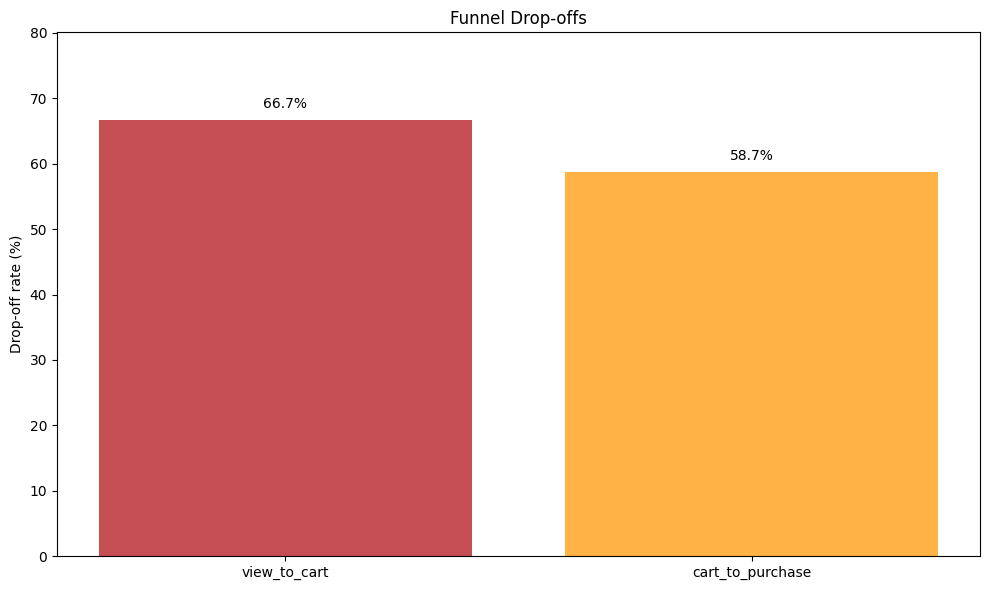

In [10]:
# Prepare and label the two funnel drop-off steps (view→cart and cart→purchase)
labels = ['view_to_cart', 'cart_to_purchase']
dropoffs = [dropoff_view_to_cart, dropoff_cart_to_purchase]

# Convert fractional drop-offs to percentage values for plotting
percent = [d * 100 for d in dropoffs]

# Create a figure and axis for the bar chart and draw bars with custom colors
fig, ax = plt.subplots(figsize=(10,6))

# Annotate each bar with its percentage value just above the bar center
bars = ax.bar(labels, percent, color=['#c44e52', '#ffb347'])
for bar, p in zip(bars, percent):
    ax.text(bar.get_x() + bar.get_width() / 2, p + max(percent)*0.02, f'{p:.1f}%', ha='center', va='bottom')

# Set y-axis label, chart title, and add some top margin to the y-limit for annotation space
ax.set_ylabel('Drop-off rate (%)')
ax.set_title('Funnel Drop-offs')
ax.set_ylim(0, max(percent) * 1.2)

# Tighten layout and display the plot
plt.tight_layout()
plt.show()

### Segment wise funnel comparison

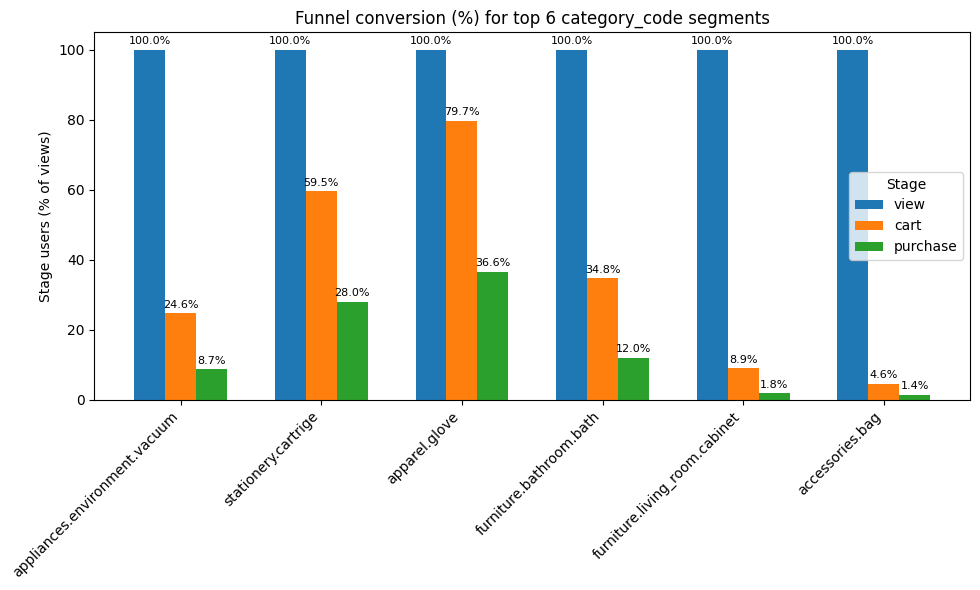

In [11]:
# Segment-wise funnel comparison by top product categories (shows stage % relative to views)
segment_col = "category_code"
top_n = 6

# build funnel counts per segment and ensure stage order
seg_funnel = df.groupby([segment_col, "event_type"])["user_id"].nunique().unstack(fill_value=0)
seg_funnel = seg_funnel.reindex(columns=stages).fillna(0)

# pick top segments by views
top_segments = seg_funnel["view"].sort_values(ascending=False).head(top_n).index
sf = seg_funnel.loc[top_segments]

# normalize to views to get stage conversion (%) per segment
sf_pct = sf.div(sf["view"], axis=0) * 100

# plot grouped bars: for each segment show view/cart/purchase %
x = np.arange(len(sf_pct))
width = 0.22

fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, stage in enumerate(stages):
    ax2.bar(x + (i - 1) * width, sf_pct[stage], width, label=stage)

# annotations
for i in range(len(sf_pct)):
    for j, stage in enumerate(stages):
        val = sf_pct.iloc[i][stage]
        ax2.text(x[i] + (j - 1) * width, val + 1, f"{val:.1f}%", ha='center', va='bottom', fontsize=8)

ax2.set_xticks(x)
ax2.set_xticklabels(sf_pct.index, rotation=45, ha='right')
ax2.set_ylabel("Stage users (% of views)")
ax2.set_title(f"Funnel conversion (%) for top {top_n} {segment_col} segments")
ax2.legend(title="Stage")
plt.tight_layout()
plt.show()

### Conversion rates

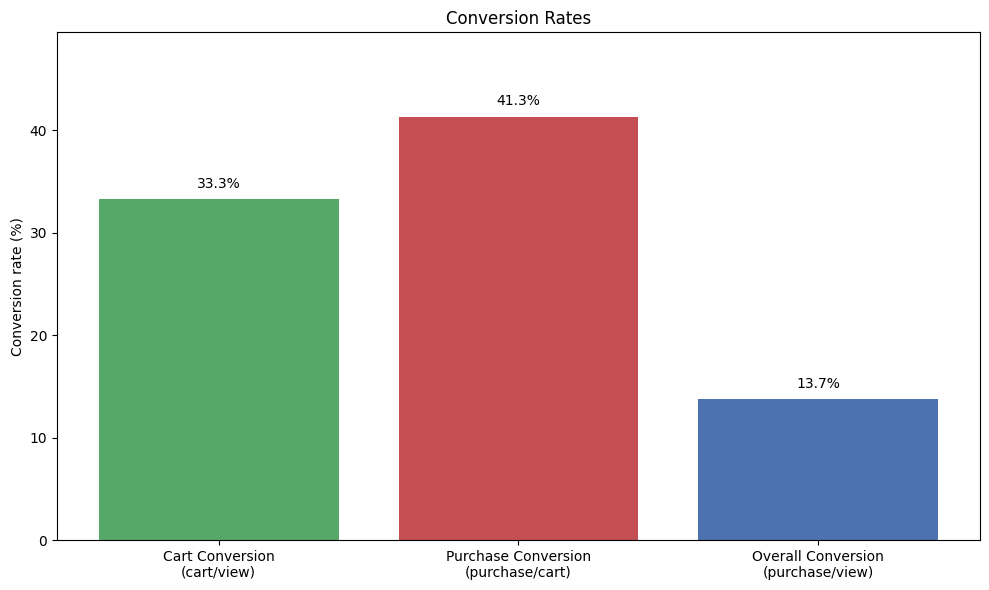

In [12]:
# plot conversion rates: cart, purchase, overall
fig_conv, ax_conv = plt.subplots(figsize=(10, 6))
rates = [cart_conversion, purchase_conversion, overall_conversion]
labels = ['Cart Conversion\n(cart/view)', 'Purchase Conversion\n(purchase/cart)', 'Overall Conversion\n(purchase/view)']
percent = [r * 100 for r in rates]
colors_conv = ['#55a868', '#c44e52', '#4c72b0']

bars = ax_conv.bar(labels, percent, color=colors_conv)
for bar, p in zip(bars, percent):
    ax_conv.text(bar.get_x() + bar.get_width() / 2, p + max(percent) * 0.02, f'{p:.1f}%', ha='center', va='bottom')

ax_conv.set_ylabel('Conversion rate (%)')
ax_conv.set_title('Conversion Rates')
ax_conv.set_ylim(0, max(percent) * 1.2)
plt.tight_layout()
plt.show()

## 9. Insights

### Time-to-conversion insights

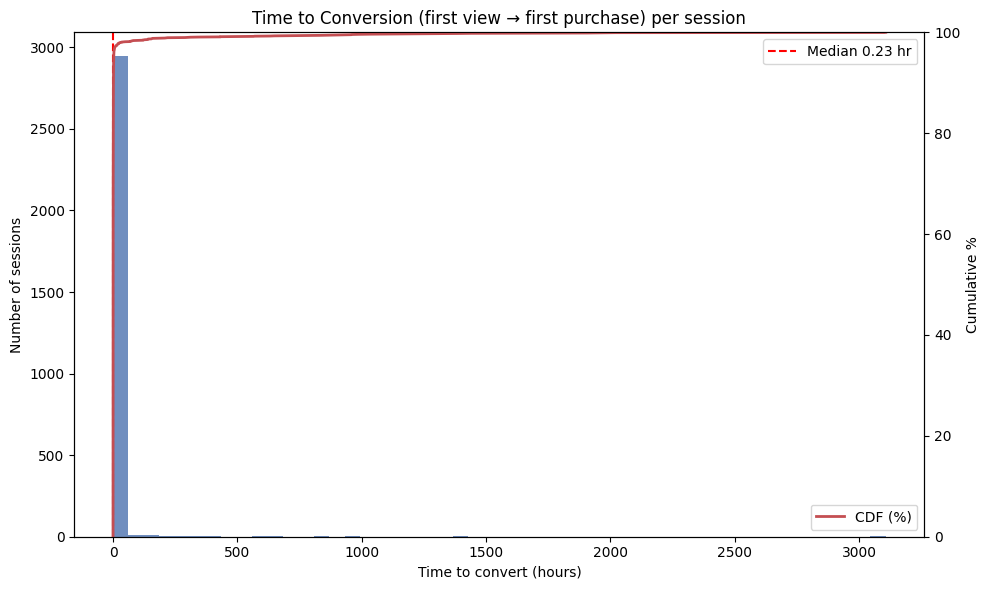

In [13]:
# Time-to-conversion per session: time from first view -> first purchase
views = df[df["event_type"] == "view"].groupby("user_session")["event_time"].min().rename("first_view")
purchases = df[df["event_type"] == "purchase"].groupby("user_session")["event_time"].min().rename("first_purchase")
conv = pd.concat([views, purchases], axis=1).dropna()
conv["time_to_convert_hr"] = (conv["first_purchase"] - conv["first_view"]).dt.total_seconds() / 3600
conv = conv[conv["time_to_convert_hr"] >= 0]

if conv.empty:
    print("No sessions with both view and purchase found.")
else:
    median_hr = conv["time_to_convert_hr"].median()
    mean_hr = conv["time_to_convert_hr"].mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    bins = min(50, max(10, int(len(conv) ** 0.5)))
    ax.hist(conv["time_to_convert_hr"], bins=bins, color="#4c72b0", alpha=0.8)
    ax.axvline(median_hr, color="red", linestyle="--", label=f"Median {median_hr:.2f} hr")
    ax.set_xlabel("Time to convert (hours)")
    ax.set_ylabel("Number of sessions")
    ax.set_title("Time to Conversion (first view → first purchase) per session")

    # CDF on secondary axis
    ax2 = ax.twinx()
    sorted_vals = np.sort(conv["time_to_convert_hr"].values)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals) * 100
    ax2.plot(sorted_vals, cdf, color="#c44e52", linewidth=2, label="CDF (%)")
    ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100)

    ax.legend(loc="upper right")
    ax2.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

/var/folders/3n/7hcbgwc533l0mf1xhbrw2dg00000gn/T/ipykernel_21568/2976445465.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(purchase_pct.index, rotation=45, ha='right')


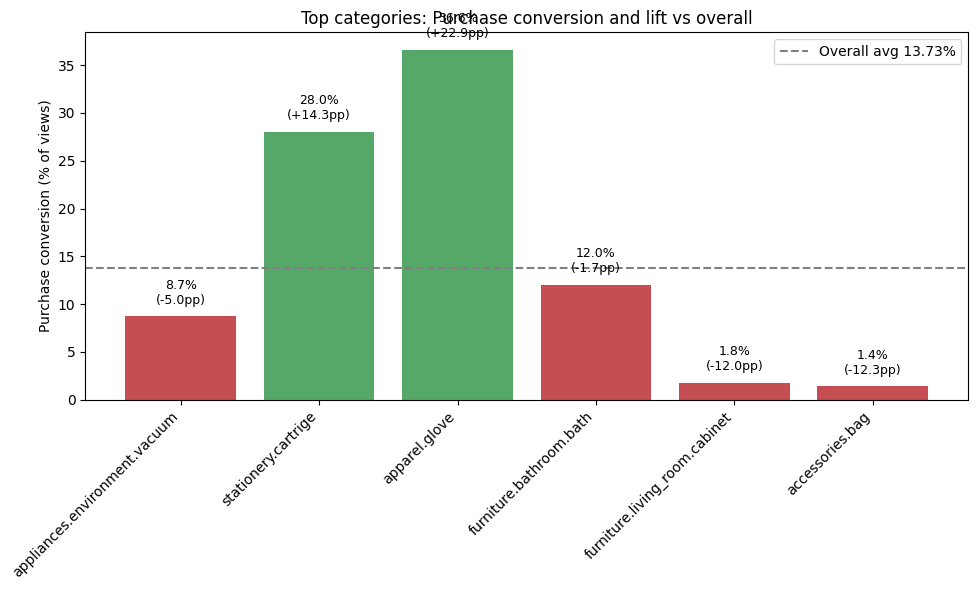

In [ ]:
# Quantified insight: purchase conversion (%) for top segments and lift vs overall conversion
purchase_pct = sf_pct['purchase']
# overall conversion in percent
avg_pct = overall_conversion * 100

fig, ax3 = plt.subplots(figsize=(10, 6))
colors = ['#55a868' if v >= avg_pct else '#c44e52' for v in purchase_pct]
bars = ax3.bar(purchase_pct.index, purchase_pct.values, color=colors)
ax3.axhline(avg_pct, color='gray', linestyle='--', label=f'Overall avg {avg_pct:.2f}%')

for bar, val in zip(bars, purchase_pct.values):
    lift = val - avg_pct
    sign = '+' if lift >= 0 else ''
    ax3.text(bar.get_x() + bar.get_width() / 2, val + 1, f"{val:.1f}%\n({sign}{lift:.1f}pp)", ha='center', va='bottom', fontsize=9)

ax3.set_ylabel('Purchase conversion (% of views)')
ax3.set_title('Top categories: Purchase conversion and lift vs overall')
ax3.set_xticklabels(purchase_pct.index, rotation=45, ha='right')
ax3.legend()
plt.tight_layout()
plt.show()

## 10. Business Recommendations

/var/folders/3n/7hcbgwc533l0mf1xhbrw2dg00000gn/T/ipykernel_21568/1836656543.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axR.set_xticklabels(purchase_pct.index, rotation=45, ha='right')


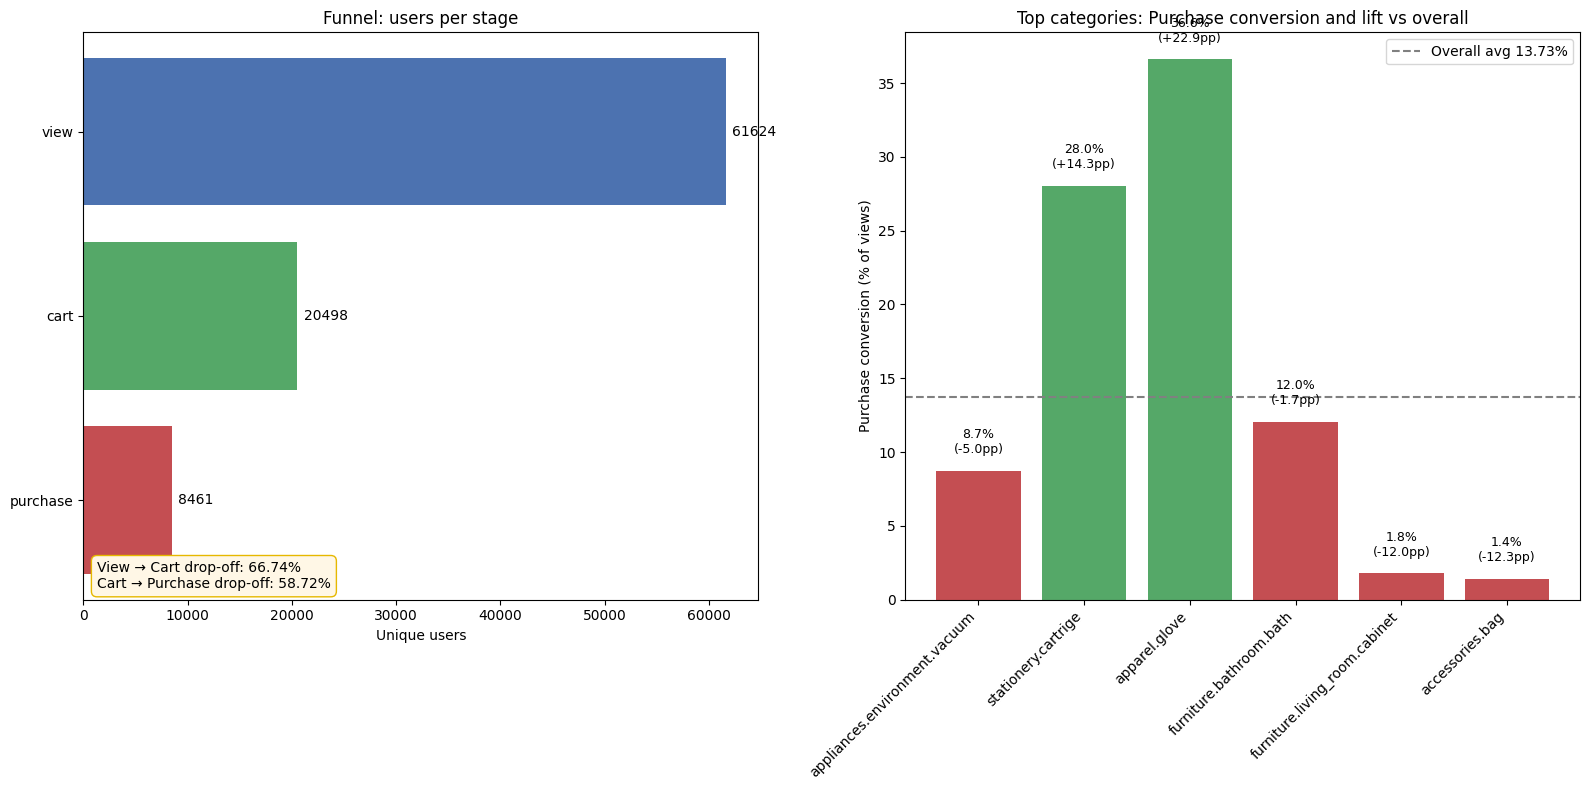

In [18]:
# Recommendation visualization: highlight drop-offs and segment actions
fig, (axL, axR) = plt.subplots(1, 2, figsize=(16, 8))

# Left: funnel counts + dropoffs
counts_plot = counts.reindex(stages).fillna(0).astype(int)
axL.barh(stages, counts_plot, color=['#4c72b0', '#55a868', '#c44e52'])
axL.invert_yaxis()
for i, val in enumerate(counts_plot.values):
    axL.text(val + counts_plot.max()*0.01, i, f"{val}", va='center')
axL.set_xlabel('Unique users')
axL.set_title('Funnel: users per stage')
drop_text = (f"View → Cart drop-off: {dropoff_view_to_cart*100:.2f}%\n"
             f"Cart → Purchase drop-off: {dropoff_cart_to_purchase*100:.2f}%")
axL.text(0.02, 0.02, drop_text, transform=axL.transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.4", facecolor="#fff7e6", edgecolor="#e6b800"))

# Right: top segments purchase conversion vs overall, with lift
colors_rec = ['#55a868' if v >= avg_pct else '#c44e52' for v in purchase_pct.values]
bars_seg = axR.bar(purchase_pct.index, purchase_pct.values, color=colors_rec)
axR.axhline(avg_pct, color='gray', linestyle='--', label=f'Overall avg {avg_pct:.2f}%')
for bar, val in zip(bars_seg, purchase_pct.values):
    lift = val - avg_pct
    sign = '+' if lift >= 0 else ''
    axR.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%\n({sign}{lift:.1f}pp)",
              ha='center', va='bottom', fontsize=9)
axR.set_ylabel('Purchase conversion (% of views)')
axR.set_title('Top categories: Purchase conversion and lift vs overall')
axR.set_xticklabels(purchase_pct.index, rotation=45, ha='right')
axR.legend()

# Compact business recommendations (use insights above)
plt.tight_layout()
plt.show()

####  1) Fix product-page experience for high view→cart drop-off (e.g. appliances.environment.vacuum).
####  2) Reduce checkout friction & test pricing/promos to recover cart→purchase drop-offs.
####  3) Invest in/scale wins (above-average: apparel.glove, stationery.cartrige); test paid traffic.
####  4) For high-view low-convert segments, run targeted experiments (UX, images, trust signals).
